(cluster_ntbk)=

# Cluster analysis

In [30]:
%config InlineBackend.figure_format = "retina"


The first step in the analysis of a stellar cluster is to load the data file as a [asteca.cluster](https://asteca.readthedocs.io/en/latest/apidocs/asteca/asteca.cluster.html) object, the user can employ the library of their choice. For example, the [pandas](https://pandas.pydata.org/) library allows you to easily read a [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file as a [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):

In [31]:
import pandas as pd

# Load the observed cluster with pandas. This is an example cluster
# used for this notebook, containing Gaia DR3 data
clust_df = pd.read_csv("../_static/field.csv")
clust_df

,DR3Name,RA_ICRS,DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,Gmag,e_Gmag,BP-RP,e_BP-RP
0,1,6.9702,61.0644,0.4155,0.1298,4.723,-4.596,0.113,-1.088,0.126,18.236310,0.003055,1.417509,0.0181
1,2,6.9730,61.0663,0.1394,0.1147,0.728,-0.709,0.101,0.164,0.115,18.068916,0.002972,1.489637,0.0251
2,3,6.9929,61.0615,0.1798,0.0815,1.397,-1.345,0.075,0.374,0.071,17.406872,0.002857,1.895990,0.0133
3,4,6.8977,61.0641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.103613,0.007146,1.127492,0.0262
4,5,6.9032,61.0656,0.2339,0.0175,2.666,-2.651,0.017,0.277,0.018,14.180438,0.002762,1.828795,0.0049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8678,8679,5.8419,61.5723,0.3010,0.0532,2.920,-2.422,0.048,-1.631,0.049,16.835844,0.002816,1.374006,0.0101
8679,8680,5.8271,61.5857,0.3655,0.0938,1.047,0.623,0.083,-0.842,0.082,17.654474,0.002899,1.352100,0.0132
8680,8681,5.8430,61.5898,0.6432,0.1565,3.109,-3.059,0.144,-0.553,0.148,17.699040,0.003224,1.523220,0.0131
8681,8682,5.8384,61.5882,0.3607,0.1222,2.758,-2.755,0.109,0.130,0.116,18.355470,0.003012,1.699585,0.0230


Passing this data to the `asteca.cluster` class creates an object with the desired, which we call here `my_field`:

In [32]:
import asteca

my_field = asteca.cluster(
    ra=clust_df["RA_ICRS"],
    dec=clust_df["DE_ICRS"],
    magnitude=clust_df["Gmag"],
    e_mag=clust_df["e_Gmag"],
    color=clust_df["BP-RP"],
    e_color=clust_df["e_BP-RP"],
    pmra=clust_df["pmRA"],
    pmde=clust_df["pmDE"],
    plx=clust_df["Plx"],
    e_pmra=clust_df["e_pmRA"],
    e_pmde=clust_df["e_pmDE"],
    e_plx=clust_df["e_Plx"],
    verbose=2                   # Print info to screen
)


Instantiating cluster...
Columns read   : RA, DEC, Magnitude, e_mag, Color, e_color, Plx, pmRA, pmDE
N_stars        : 8683
N_clust_min    : 25
N_clust_max    : 5000
Cluster object generated


We can generate a simple plot to see how our loaded data looks like:

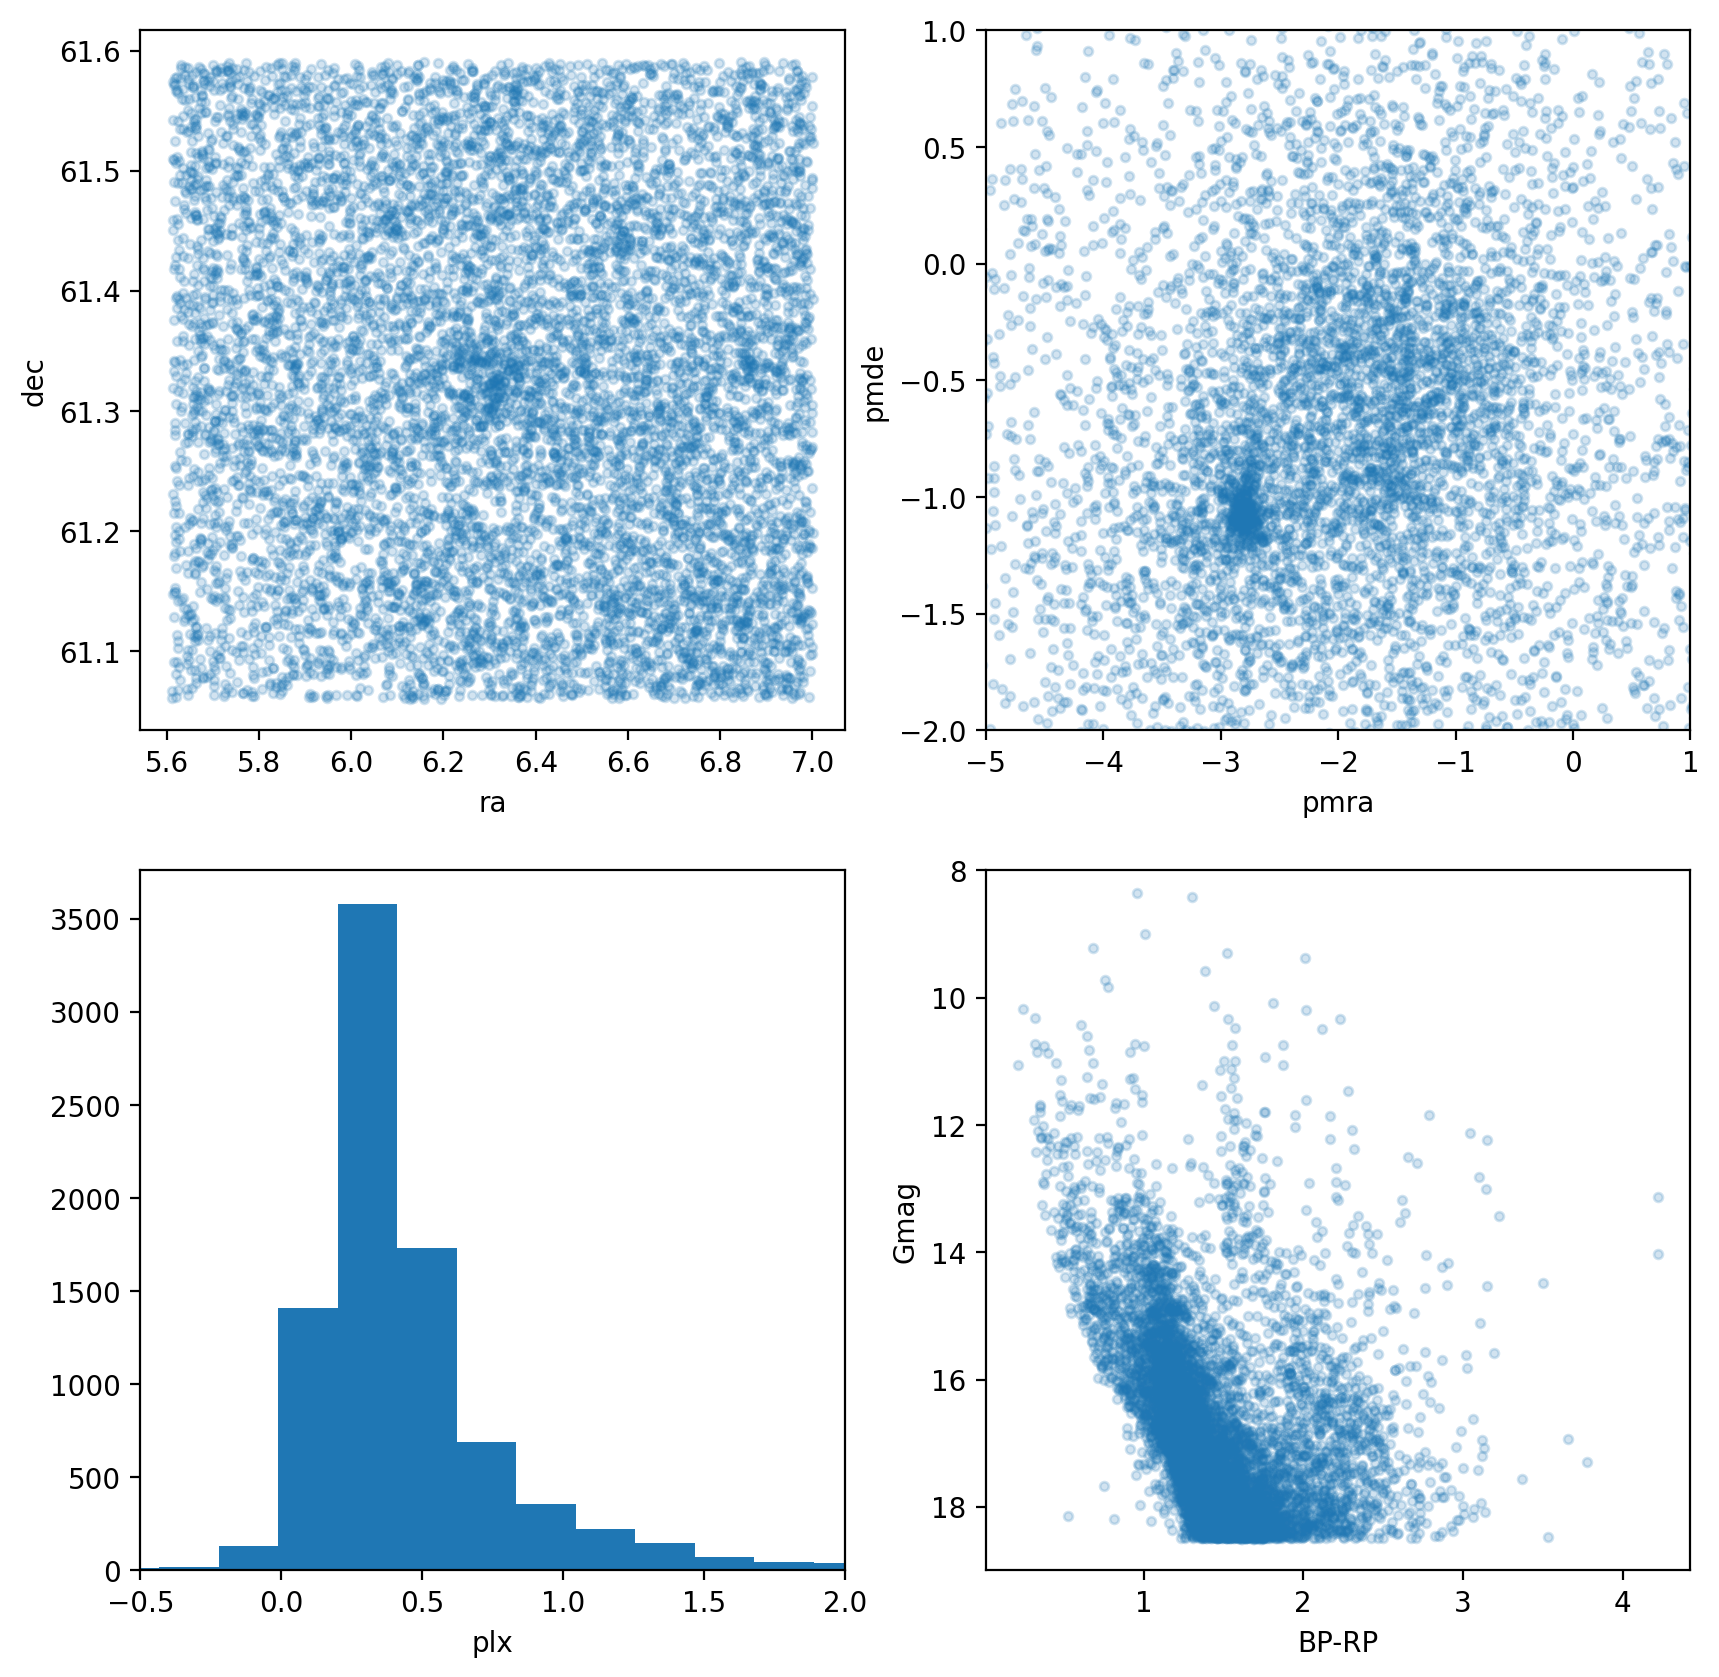

In [33]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

ax1.scatter(my_field.ra, my_field.dec, alpha=.2, s=10)
ax1.set_xlabel("ra")
ax1.set_ylabel("dec")

ax2.scatter(my_field.pmra, my_field.pmde, alpha=.2, s=10)
ax2.set_xlim(-5, 1)  # Zoom in to better see the density
ax2.set_ylim(-2, 1)
ax2.set_xlabel("pmra")
ax2.set_ylabel("pmde")

ax3.hist(my_field.plx, 100)
ax3.set_xlim(-0.5, 2)
ax3.set_xlabel("plx")

ax4.scatter(my_field.color, my_field.mag, alpha=.2, s=10)
ax4.set_ylim(19, 8)
ax4.set_xlabel("BP-RP")
ax4.set_ylabel("Gmag");

 We can see that this is an _observed field_, and not a data file with the cluster member's already identified.

## Center and radius estimation

To estimate the center 

In [5]:
# Estimate the cluster's center coordinates, use the default algorithm
my_field.get_center()


Center coordinates found

Number of members estimated


With the required parameters loaded in the `my_field` object, we can instantiate a `membership` object as follows:

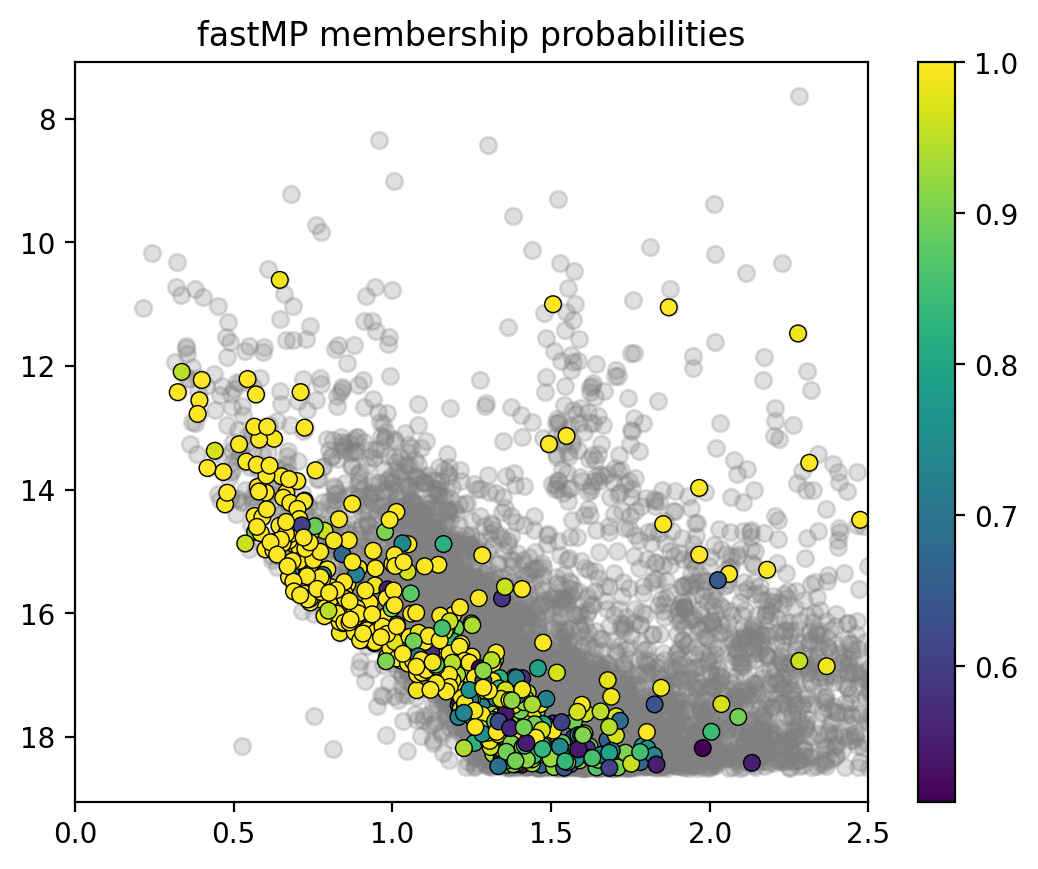

In [8]:
# Plot CMD
plt.title("fastMP membership probabilities")
plt.scatter(field_df['BP-RP'], field_df['Gmag'], c='grey', alpha=.25)
msk = probs_fastmp > 0.5
plt.scatter(field_df['BP-RP'][msk], field_df['Gmag'][msk], c=probs_fastmp[msk], ec='k', lw=.5)
plt.gca().invert_yaxis()
plt.xlim(0, 2.5)
plt.colorbar();

## Bayesian method

As stated in the in the [Membership estimation](https://asteca.readthedocs.io/en/latest/basic/membership.html) section, the `bayesian` method shold only be preferred over `fastmp` when there is no proper motions and parallax data available. In those cases, the `fastmp` method will most likely give better results.

We will show here how the `bayesian` method can be used with photometric data exclusively. We thus re-instantiate a `cluster` object without proper motions and parallax data:

Now we need to estimate the center coordinates and number of members (just like with `fastmp`) and in addition we need to add a `radius` argument (which is not required for `fastmp`):

In [10]:
# Estimate the cluster's center coordinates, using the `kde_2d` algorithm and (RA, DEC) data
my_field.get_center("kde_2d", data_2d=("radec"))

# Add a radius attribute manually (there is no method included in ASteCA to estimate
# the radius parameter yet)
my_field.radius = 0.09  # in degrees

# Estimate the number of cluster members, using the `density` algorithm
my_field.get_nmembers("density")


Center coordinates found
radec_c        : (6.3142, 61.3262)

Number of members estimated
N_cluster      : 247


Now we can instantiate the `membership` object and obtain the membership probabilities using the `bayesian` method:


Membership object generated
N_cluster      : 247
Random seed    : None

Running Bayesian DA...
radec_c        : (6.3142, 61.3262)
radius         : 0.0900 [deg]
N_cluster      : 247
N_runs         : 1000
Convergence reached at 92 runs


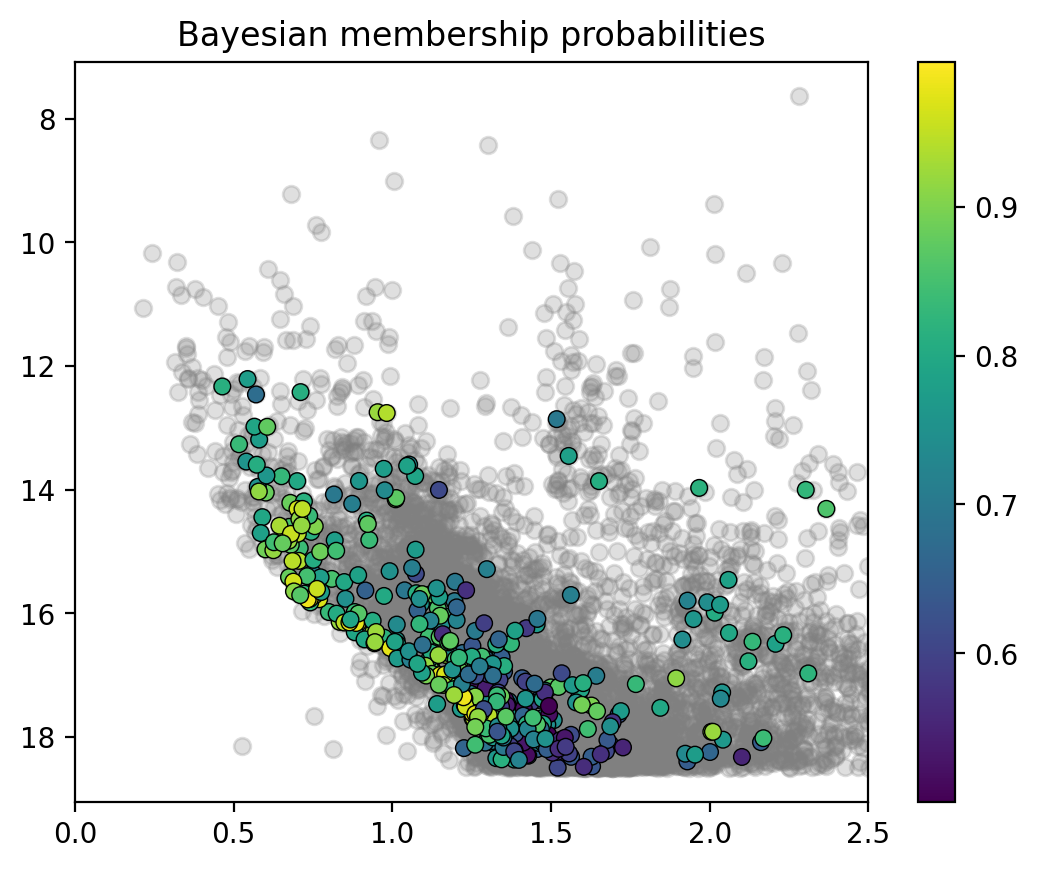

In [11]:
# Define a `membership` object
memb = asteca.membership(my_field, verbose=2)

# Run `bayesian` method
probs_bayes = memb.bayesian()

# Plot CMD
plt.title("Bayesian membership probabilities")
plt.scatter(field_df['BP-RP'], field_df['Gmag'], c='grey', alpha=.25)
msk = probs_bayes > 0.5
plt.scatter(field_df['BP-RP'][msk], field_df['Gmag'][msk], c=probs_bayes[msk], ec='k', lw=.5)
plt.gca().invert_yaxis()
plt.xlim(0, 2.5)
plt.colorbar();

A side-by-side plot of the CMDs shows that the stars with P>50% selected by each of the methods are not necessarily the same, as is their assigned membership probabilities.

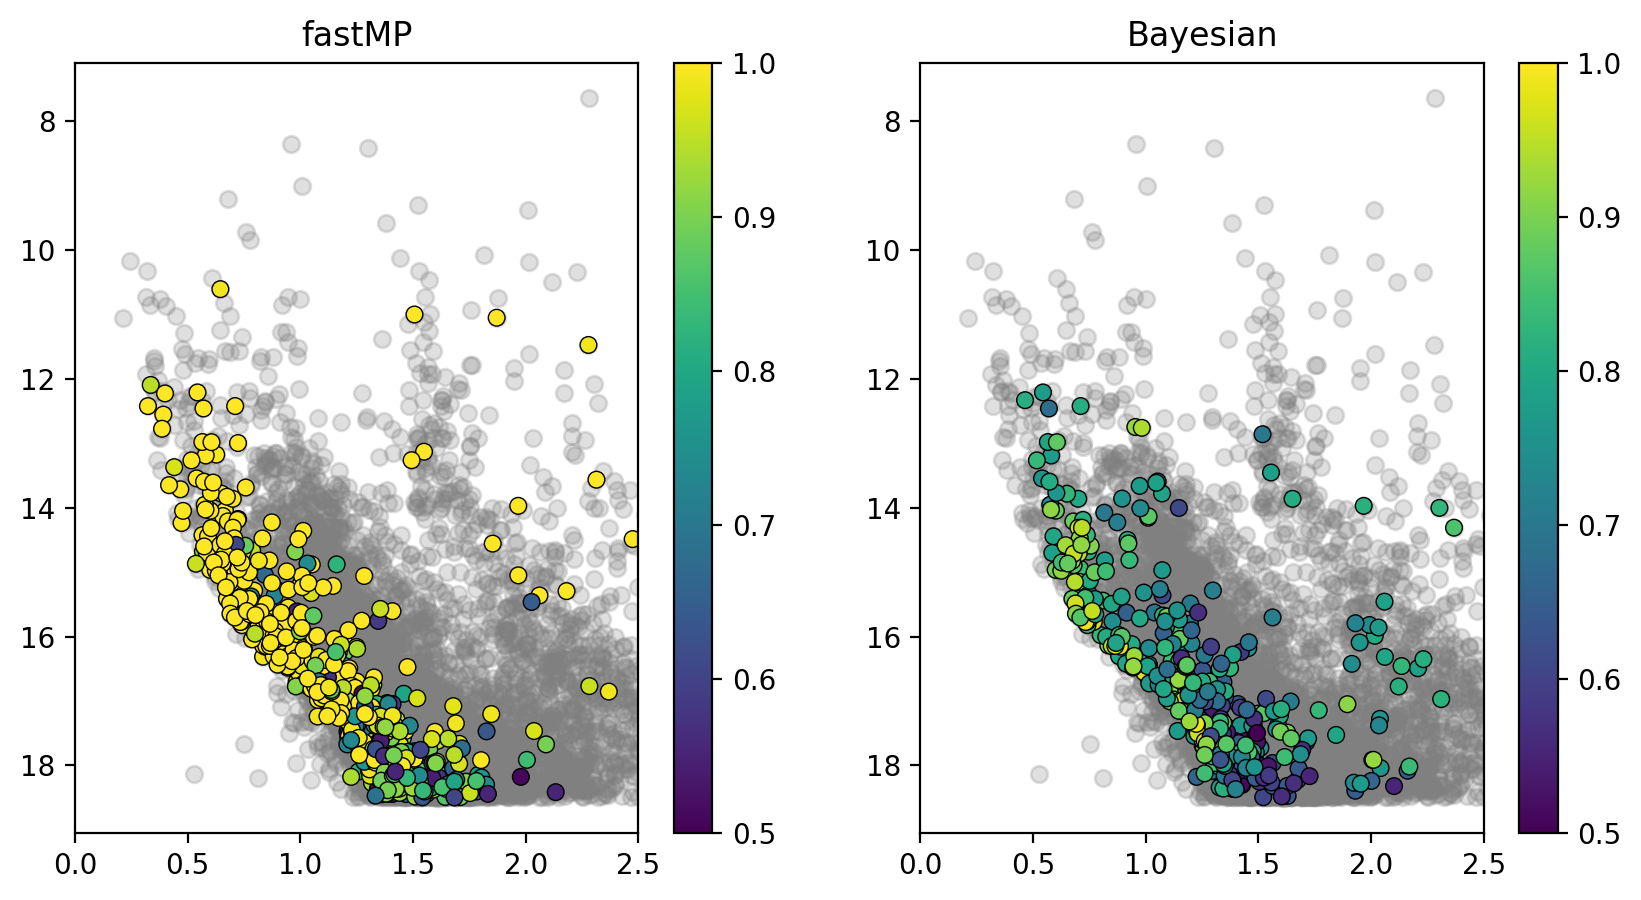

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# fastMP membership
ax1.set_title("fastMP")
ax1.scatter(field_df['BP-RP'], field_df['Gmag'], c='grey', alpha=.25)
msk = probs_fastmp > 0.5
im1= ax1.scatter(field_df['BP-RP'][msk], field_df['Gmag'][msk], c=probs_fastmp[msk], ec='k', lw=.5, vmin=0.5, vmax=1)
ax1.invert_yaxis()
ax1.set_xlim(0, 2.5)
fig.colorbar(im1, ax=ax1)

# Bayesian memberhsip
ax2.set_title("Bayesian")
ax2.scatter(field_df['BP-RP'], field_df['Gmag'], c='grey', alpha=.25)
msk = probs_bayes > 0.5
im2 = ax2.scatter(field_df['BP-RP'][msk], field_df['Gmag'][msk], c=probs_bayes[msk], ec='k', lw=.5, vmin=0.5, vmax=1)
ax2.invert_yaxis()
ax2.set_xlim(0, 2.5)
fig.colorbar(im2, ax=ax2);